In [9]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from PIL import Image
import os
import csv
import random
import gc
from keras.models import Model
import data_loader
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Method to extract features from a given image
def extract_features(image, verbose=None):
    base_model = tf.keras.applications.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv2').output)
    img_features = model.predict(np.expand_dims(image, axis=0), verbose=verbose)
    return img_features.flatten()

In [4]:
# Method to calculate the average distance between two clusters
def calculate_cluster_distance(cluster_1, cluster_2):
    distances_cluster1 = np.sqrt(np.sum((cluster_1[:, np.newaxis] - cluster_1) ** 2, axis=-1))
    distances_cluster2 = np.sqrt(np.sum((cluster_2[:, np.newaxis] - cluster_2) ** 2, axis=-1))
    
    # Calculate the average distance between clusters
    avg_distance = (np.sum(distances_cluster1) + np.sum(distances_cluster2)) / (len(cluster_1) * len(cluster_2))
    return avg_distance


In [5]:
# Import Data
input_path = 'tf/input'
train_data, test_data, val_data = data_loader.get_data_unbatched(input_path)

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [6]:
# Create a list where each entry corresponds to one class containing a list of all the filepaths
with open('tf/input/birds.csv', 'r') as csv_file:
    reader = csv.DictReader(csv_file)
    paths_by_label = {}
    for row in reader:
        image_path = row['filepaths']
        label = row['labels']
        # Check if label exists already
        if label in paths_by_label:
            paths_by_label[label].append(image_path)
        else:
            paths_by_label[label] = [image_path]

# Convert the dictionary to a list
list_of_paths_by_label = list(paths_by_label.values())

# Verify correctness of the sorting process
print(list_of_paths_by_label[0])

# Print the result
"""
for idx, paths in enumerate(list_of_paths_by_label):
    print(f"Class {idx + 1}: {paths}")
"""

['train/ABBOTTS BABBLER/001.jpg', 'train/ABBOTTS BABBLER/007.jpg', 'train/ABBOTTS BABBLER/008.jpg', 'train/ABBOTTS BABBLER/009.jpg', 'train/ABBOTTS BABBLER/002.jpg', 'train/ABBOTTS BABBLER/003.jpg', 'train/ABBOTTS BABBLER/004.jpg', 'train/ABBOTTS BABBLER/005.jpg', 'train/ABBOTTS BABBLER/006.jpg', 'train/ABBOTTS BABBLER/010.jpg', 'train/ABBOTTS BABBLER/016.jpg', 'train/ABBOTTS BABBLER/017.jpg', 'train/ABBOTTS BABBLER/039.jpg', 'train/ABBOTTS BABBLER/040.jpg', 'train/ABBOTTS BABBLER/023.jpg', 'train/ABBOTTS BABBLER/025.jpg', 'train/ABBOTTS BABBLER/027.jpg', 'train/ABBOTTS BABBLER/015.jpg', 'train/ABBOTTS BABBLER/077.jpg', 'train/ABBOTTS BABBLER/014.jpg', 'train/ABBOTTS BABBLER/073.jpg', 'train/ABBOTTS BABBLER/024.jpg', 'train/ABBOTTS BABBLER/032.jpg', 'train/ABBOTTS BABBLER/026.jpg', 'train/ABBOTTS BABBLER/034.jpg', 'train/ABBOTTS BABBLER/028.jpg', 'train/ABBOTTS BABBLER/036.jpg', 'train/ABBOTTS BABBLER/022.jpg', 'train/ABBOTTS BABBLER/038.jpg', 'train/ABBOTTS BABBLER/021.jpg', 'train/AB

'\nfor idx, paths in enumerate(list_of_paths_by_label):\n    print(f"Class {idx + 1}: {paths}")\n'

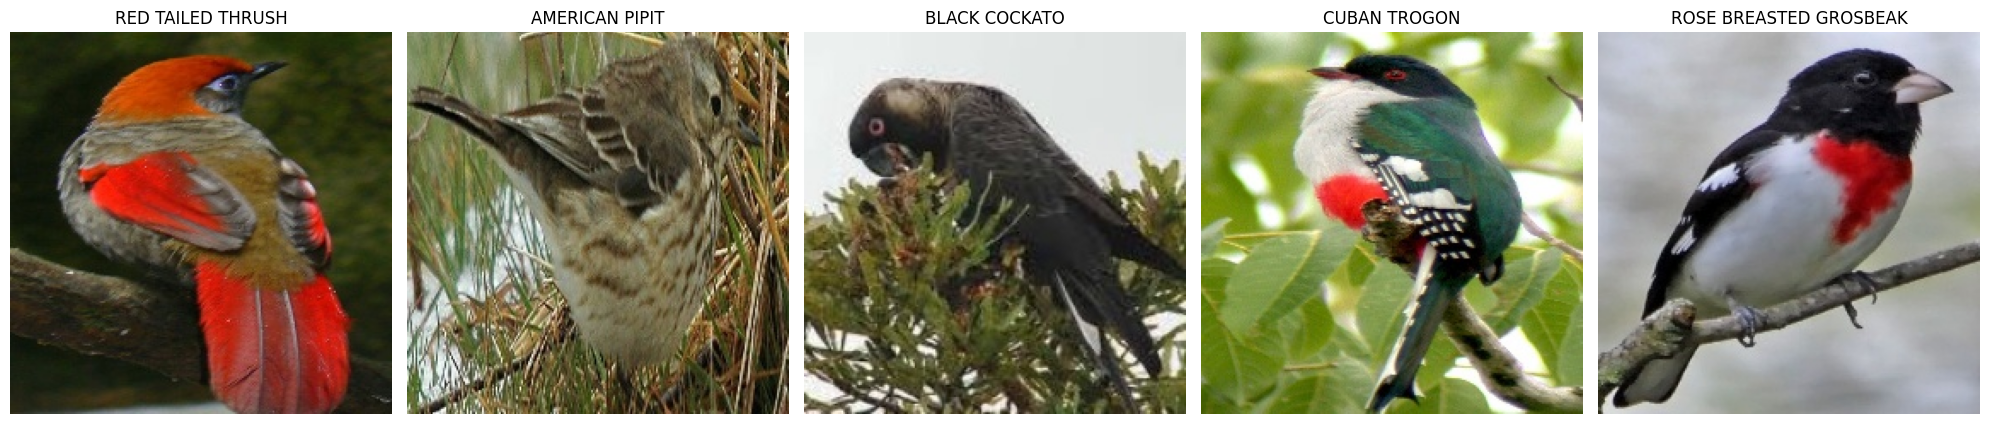

In [7]:
# Show n random images of a random class
paths = random.sample(sum(list_of_paths_by_label, []), 5)

# Display 5 images side by side
fig, axes = plt.subplots(1, 5, figsize=(20, 20))

for i, img_path in enumerate(paths):
    full_path = os.path.join('tf/input', img_path)
    img = Image.open(full_path)
    img_label = img_path.split('/')[1]
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(img_label)

plt.tight_layout()
plt.show()

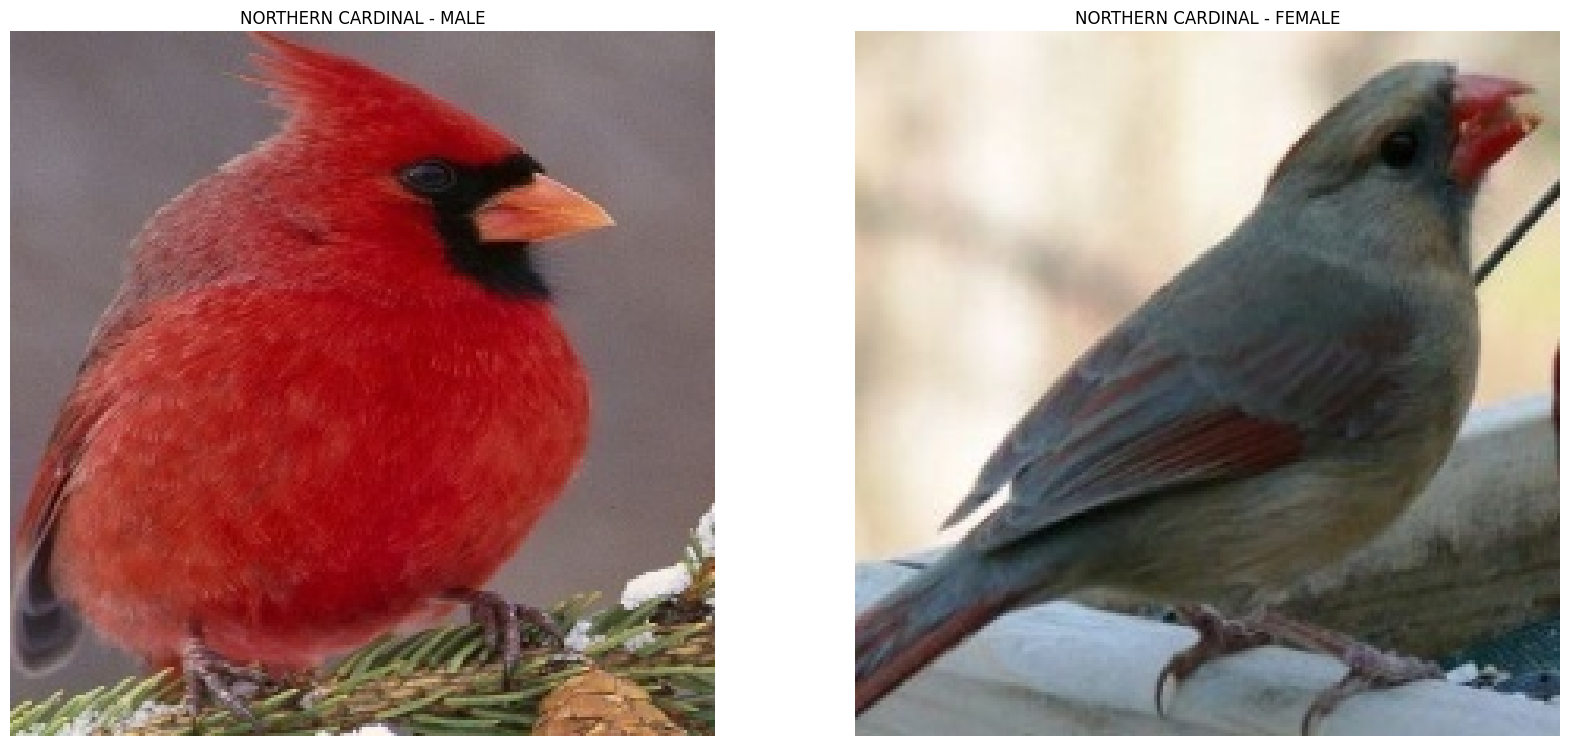

In [7]:
# Inspection of the northern cardinal

# By manual research, we take the Northern Cardinal as an example of a non-monomorphic species.
# The difference of males and females are clearly visible:

fig, axes = plt.subplots(1, 2, figsize=(20, 20))
nc_paths = ['train/NORTHERN CARDINAL/019.jpg', 'train/NORTHERN CARDINAL/010.jpg']
for i, img_path in enumerate(nc_paths):
    full_path = os.path.join('tf/input', img_path)
    img = Image.open(full_path)
    img_label = img_path.split('/')[1]
    if i == 0:
        img_label = f'{img_label} - MALE'
    else:
        img_label = f'{img_label} - FEMALE'
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(img_label)

In [8]:
# Extract features for the Northern Cardinal:

nc_img_paths = paths_by_label['NORTHERN CARDINAL']
all_features = []

for img_path in nc_img_paths:
    full_path = os.path.join('tf/input', img_path)
    img = Image.open(full_path)
    img_matrix = np.array(img)
    features = extract_features(img_matrix)
    all_features.append(features)

all_features = np.array(all_features)

# Standardise
scaler = StandardScaler()
scaled_features = scaler.fit_transform(all_features)

2023-12-20 12:44:48.745095: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-20 12:44:48.745565: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


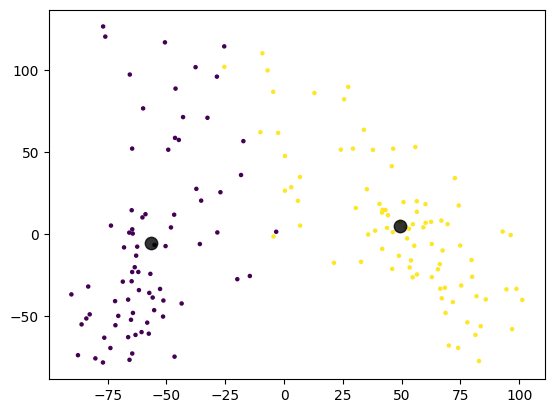

In [9]:
# Run PCA on features for the Northern Cardinal

num_components = 10
pca = PCA(n_components=num_components)
reduced_features = pca.fit_transform(scaled_features)

# Step 6: Apply KMeans clustering to each class

clusters = KMeans(n_clusters=2, n_init="auto").fit(reduced_features)
y_kmeans = clusters.predict(reduced_features)
# Retrieve scores (SSE)
score = clusters.score(reduced_features)
# Retrieve cluster centers
cntr = clusters.cluster_centers_
# Create subplots
X = reduced_features
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=5)
plt.scatter(cntr[:, 0], cntr[:, 1], c='black', s=80, alpha=0.8)
plt.show()

In [10]:
# Calculate distance between clusters
cluster = []
for cluster_idx in range(2):
    cluster_points = reduced_features[y_kmeans == cluster_idx]
    cluster.append(cluster_points)

dist = calculate_cluster_distance(cluster[0], cluster[1])
print(dist)

314.84253246753246


Now we calculated the average cluster distance for one species.
The idea is to repeat this process for every species and compare the distance. We want to find a threshold so that we can tell if a distance between clusters is large enough to say that this specific species is non-monomorphic.

In [14]:
cluster_distances = []
progress_counter = 0

clustering_results_path = 'clustering_results.csv'

# If csv file does not exist, create it
if not os.path.exists(clustering_results_path):
    with open(clustering_results_path, 'w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=['label', 'cluster_distance'])
        writer.writeheader()

# Read csv and determine the labels that don't need to be calculated
already_calculated = []
label_column = 'label'
with open(clustering_results_path, 'r') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        already_calculated.append(row[label_column])

# Calculate cluster distances
for species_path in list_of_paths_by_label:
    
    # Keep track of overall progress (executing this block takes some time) 
    progress_counter += 1
    print(f'Processing class {progress_counter} out of {len(list_of_paths_by_label)}')

    # Check if the cluster distance was already calculated
    if not species_path[0].split('/')[1] in already_calculated:
        all_features = []    
        for img_path in species_path:
            full_path = os.path.join('tf/input', img_path)
            img = Image.open(full_path)
            img_matrix = np.array(img)
            features = extract_features(img_matrix)
            all_features.append(features)
            # Free space after each iteration
            del img
            del img_matrix
            del features
            gc.collect()
        
        all_features = np.array(all_features)
        
        # Standardise
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(all_features)
        
        num_components = 10
        pca = PCA(n_components=num_components)
        reduced_features = pca.fit_transform(scaled_features)
        
        # Step 6: Apply KMeans clustering to each class
        clusters = KMeans(n_clusters=2, n_init="auto").fit(reduced_features)
        y_kmeans = clusters.predict(reduced_features)
        
        cluster = []
        for cluster_idx in range(2):
            cluster_points = reduced_features[y_kmeans == cluster_idx]
            cluster.append(cluster_points)
        
        dist = calculate_cluster_distance(cluster[0], cluster[1])
        cluster_distances.append(dist)
        print(f'Cluster distance: {dist}')
        # Append csv file
        with open(clustering_results_path, 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([species_path[0].split('/')[1], dist])
    

Processing class 1 out of 525
Processing class 2 out of 525
Processing class 3 out of 525
Processing class 4 out of 525
Processing class 5 out of 525
Processing class 6 out of 525
Processing class 7 out of 525
Processing class 8 out of 525
Processing class 9 out of 525
Processing class 10 out of 525
Processing class 11 out of 525
Processing class 12 out of 525
Processing class 13 out of 525
Processing class 14 out of 525
Processing class 15 out of 525
Processing class 16 out of 525
Processing class 17 out of 525
Processing class 18 out of 525
Processing class 19 out of 525
Processing class 20 out of 525
Processing class 21 out of 525
Processing class 22 out of 525
Processing class 23 out of 525
Processing class 24 out of 525
Processing class 25 out of 525
Processing class 26 out of 525
Processing class 27 out of 525
Processing class 28 out of 525
Processing class 29 out of 525
Processing class 30 out of 525
Processing class 31 out of 525
Processing class 32 out of 525
Processing class 

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f40143c56c0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


KeyboardInterrupt: 

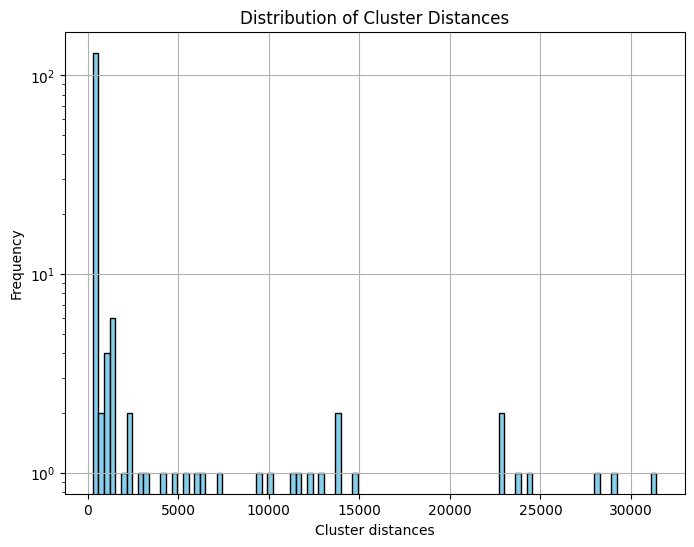

In [13]:
# Plot distribution of distances amongst the classes

n_bins = 100

df = pd.read_csv(clustering_results_path)

# Assuming your CSV file has columns 'Class' for labels and 'Values' for corresponding values
# Replace 'Class' and 'Values' with your actual column names
class_labels = df['label']
values = df['cluster_distance']

# Plotting a histogram of the values distribution
plt.figure(figsize=(8, 6))
plt.hist(values, bins=n_bins, color='skyblue', edgecolor='black')
plt.yscale('log')
plt.xlabel('Cluster distances')
plt.ylabel('Frequency')
plt.title('Distribution of Cluster Distances')
plt.grid(True)
plt.show()